In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/Project.toml`


In [3]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random

### 2D Point Mass Continous dynamics

In [4]:
c = 0.1
m = 1.0
function point_mass(x, u)
   # x = state[1]                #x_1 = ẋ
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    #y = state[3]
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [5]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end
x = [0; 0; 0 ;0]
u = [0; 0];

In [6]:
A1, B1 = lin_dyn_discrete(point_mass, x, u, 0.01)
A2, B2 = lin_dyn_discrete(point_mass, x, u, 0.01)
A = blockdiag(sparse(A1), sparse(A2))
B1Shape = size(B1)
B2Shape = size(B2)
B1 = [sparse(B1); zeros(B2Shape)]
B2 = [zeros(B1Shape); B2]

8×2 Matrix{Float64}:
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.01  0.0
 0.0   0.01

### Cost function

In [7]:
# Constraint 
obstacle = [10.0, 10.0, 0.0, 0.0]
dmax = 2.0
ρ = 500.0
# Q = 0.1*I(4) #state cost for point mass 1
# R = 10.0*I(2)
# Qn = 10.0*I(4)
function cost(Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)

    goal = x - xgoal# check x or x̂
    rel_dist = (x[1:2] - x[5:6])'*I*(x[1:2] - x[5:6])
    if B 
        return 0.5*goal'*Qni*goal #+ ρ/(exp(rel_dist))
    else            
        dx = x - xgoal
        dui = ui - uigoal
        duj = uj - ujgoal
#         c = (rel_dist - dmax)
#         if c < 0
#             c = 0.0000000000000001
#         end

        return 0.5*(dx'*Qi*dx + dui'*Rii*dui + duj'*Rij*duj) + ρ*(min(sqrt(rel_dist) - dmax, 0))^2 #- (ρ)*log2(c)
        
    end
end

cost (generic function with 1 method)

## Quadriticize the cost function

In [8]:
function quadratic_cost(cost_fun, Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q̂i = ForwardDiff.hessian(dx -> cost_fun(Qi, Rii, Rij, Qni, dx, ui, uj, xgoal, uigoal, ujgoal, B), x)
    l̂i = ForwardDiff.gradient(dx -> cost_fun(Qi, Rii, Rij, Qni, dx, ui, uj, xgoal, uigoal, ujgoal, B), x)
    R̂ii = ForwardDiff.hessian(du -> cost_fun(Qi, Rii, Rij, Qni, x, du, uj, xgoal, uigoal, ujgoal, B), ui)
    r̂ii = ForwardDiff.gradient(du -> cost_fun(Qi, Rii, Rij, Qni, x, du, uj, xgoal, uigoal, ujgoal, B), ui)
    R̂ij = ForwardDiff.hessian(du -> cost_fun(Qi, Rii, Rij, Qni, x, ui, du, xgoal, uigoal, ujgoal, B), uj)
    r̂ij = ForwardDiff.gradient(du -> cost_fun(Qi, Rii, Rij, Qni, x, ui, du, xgoal, uigoal, ujgoal, B), uj)

    if B
        dx = x - xgoal
        dui = zeros(size(ui))
        duj = zeros(size(uj))
    else
        dx = x - xgoal
        dui = ui - uigoal
        duj = uj - ujgoal
    end
    cost = 0.5 * dx' * (Q̂i*dx + 2*l̂i) + 0.5 * dui' * (R̂ii*dui + 2*r̂ii) + 0.5 * duj' * (R̂ij*duj + 2*r̂ij)
    return cost, Q̂i, l̂i, R̂ii, r̂ii, R̂ij, r̂ij
end

quadratic_cost (generic function with 1 method)

## Create costs for the 2 players

In [21]:
Q1 = sparse(zeros(8,8)) #state cost for point mass 1
Q1[1,1] = 3.0; Q1[2,2] = 3.0; Q1[3,3] = 3.0; Q1[4,4] = 3.0;
Qn1 = Q1
Q2 = sparse(zeros(8,8))   #state cost for point mass 2
Q2[5,5] = 1; Q2[6,6] = 1; Q2[7,7] = 1; Q2[8,8] = 1;
Qn2 = Q2
R11 = 1*I(2)    #Control cost for player 1
R22 = 1*I(2)    #Contorl cost for player 2
R12 = sparse(zeros(2,2))    #Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2));    #Control cost for player 2 associated with player 1's controls

In [22]:
x = [1; 2; 0 ;0; 5; 1; 0; 0]
xgoal = [1; 2; 0 ;0; 6; 2; 0; 1]
u1 = [200; 0]; u2 = [1; 0];
u1goal = [0; 0]; u2goal = [0; 0]; 
cost(Q1, R11, R12, Qn1, x, u1, u2, xgoal, u1goal, u2goal, false)

20000.0

## Player 1 

In [23]:
~, Q1, l1, R11, r11, R12, r12 = quadratic_cost(cost, Q1, R11, R12, Qn1, x, u1, u2, xgoal, u1goal, u2goal, false)

(60000.0, [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0 0.0; 0.0 1.0], [200.0, 0.0], [0.0 0.0; 0.0 0.0], [0.0, 0.0])

## Player 2

In [24]:
~, Q2, l2, R22, r22, R21, r21 = quadratic_cost(cost, Q2, R22, R21, Qn2, x, u2, u1, xgoal, u2goal, u1goal, false)

(6.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0], [1.0 0.0; 0.0 1.0], [1.0, 0.0], [0.0 0.0; 0.0 0.0], [0.0, 0.0])

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}

\begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}

In [13]:
n = 8 #8 states
m = 2 #2 controls
function lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)
    """
    Input
    Ad is an nxn matrix (8x8)
    B1d is an nxm matrix (8x2)
    B2d is an nxm matrix (8x2)
    u is mx1 (2x1)
    Q1 is an nxn matrix (8x8)
    Q2 is an nxn matrix (8x8)
    l1 is a 8x1
    R11 is an mxm matrix (2x2)
    R12 is an mxm matrix (2x2)
    R21 is an mxm matrix (2x2)
    R22 is an mxm matrix (2x2)
    Output
    P₁ is an mxn matrix (2x8)
    P₂ is an mxn matrix (2x8)
    α₁ (1x2)
    ζ₁ is an nx1 matrix (8x1)
    """
    V₁ = copy(Q1ₜ[:,:,end]) #at last time step
    V₂ = copy(Q2ₜ[:,:,end]) #at last time step

    ζ₁ = copy(l1ₜ[:,end]) #at last time step
    ζ₂ = copy(l2ₜ[:,end]) #at last time step

    P₁ = zeros(Float32, (m, n, k_steps))
    P₂ = zeros(Float32, (m, n, k_steps))
    
    α₁ = zeros(Float32, (m, k_steps))
    α₂ = zeros(Float32, (m, k_steps))

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        S11 = R11ₜ[:,:,t] + (B1ₜ[:,:,t]' * V₁ * B1ₜ[:,:,t]) #2x2
        S12 = B1ₜ[:,:,t]' * V₁ * B2ₜ[:,:,t] # 2x2
        S22 = R22ₜ[:,:,t] + (B2ₜ[:,:,t]' * V₂ * B2ₜ[:,:,t])
        S21 = B2ₜ[:,:,t]' * V₂ * B1ₜ[:,:,t]
        S = [S11 S12; S21 S22] # 4x4
        Y1 = B1ₜ[:,:,t]' * V₁ * Aₜ[:,:,t] # 2x8
        Y2 = B2ₜ[:,:,t]' * V₂ * Aₜ[:,:,t] 
        Y = [Y1; Y2] # 4 x 8
        P = S\Y # 4x8
        P₁[:,:,t] = P[1:2, :]
        P₂[:,:,t] = P[3:4, :]
        
        # solve for αs (right hand side of the eqn)
        Yα1 = (B1ₜ[:,:,t]' * ζ₁) + r11ₜ[:,t] # 2x2
        Yα2 = (B2ₜ[:,:,t]' * ζ₂) + r22ₜ[:,t] # 2x2
        Yα = [Yα1; Yα2]  # 4x2
        α = S\Yα # 4x2
        α₁[:,t] = α[1:2, :]
        α₂[:,t] = α[3:4, :]
        
        #Update value function(s)
        Fₜ = Aₜ[:,:,t] - (B1ₜ[:,:,t]*P₁[:,:,t] + B2ₜ[:,:,t]*P₂[:,:,t])
        
        βₜ = - (B1ₜ[:,:,t] * α₁[:,t] + B2ₜ[:,:,t] * α₂[:,t])
        
        ζ₁ = l1ₜ[:,t] + ((P₁[:,:,t]' * R11ₜ[:,:,t] * α₁[:,t]) - (P₁[:,:,t]' * r11ₜ[:,t])) + 
            ((P₂[:,:,t]' * R12ₜ[:,:,t] * α₂[:,t]) - (P₂[:,:,t]' * r12ₜ[:,t])) + Fₜ'*(ζ₁ + (V₁ * βₜ))
        
        ζ₂ = l2ₜ[:,t] + ((P₁[:,:,t]' * R21ₜ[:,:,t] * α₁[:,t]) - (P₁[:,:,t]' * r21ₜ[:,t])) + 
            ((P₂[:,:,t]' * R22ₜ[:,:,t] * α₂[:,t]) - (P₂[:,:,t]' * r22ₜ[:,t])) + Fₜ'*(ζ₂ + (V₂ * βₜ))
        
        V₁ = Q1ₜ[:,:,t] + (P₁[:,:,t]' * R11ₜ[:,:,t] * P₁[:,:,t]) + 
            (P₂[:,:,t]' * R12ₜ[:,:,t] * P₂[:,:,t]) + (Fₜ' * V₁ * Fₜ)
        
        V₂ = Q2ₜ[:,:,t] + (P₁[:,:,t]' * R21ₜ[:,:,t] * P₁[:,:,t]) + 
            (P₂[:,:,t]' * R22ₜ[:,:,t] * P₂[:,:,t]) + (Fₜ' * V₂ * Fₜ)
    end
    return P₁, P₂, α₁, α₂
end

lqGame! (generic function with 1 method)

In [14]:
function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α, α_scale)
    """
    Rollout dynamics with initial state x₀ 
    and control law u = -Px - α
    P is an n x b gain matrix
    α is m x 1
    """
    umax = [2,2]
    umin = [-2,-2]
    
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    uₜ = zeros(k_steps, m)
    xₜ[1,:] .= x₀
    for t=1:(k_steps-1)
        # WHAT IS x̂ in xₜ[t,:] - x̂
        #uₜ[t,:] .= clamp.([0,0] - P[:,:,t]*(xₜ[t,:] - [20,20,0,0]) - α[:,t], umin, umax)
        uₜ[t,:] .= clamp.(û[t,:] - P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[:,t], umin, umax)
        k1 = fun(xₜ[t,:], uₜ[t,:])
        k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
        k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
        k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
        xₜ[t+1,:] .= xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    end
    
    return xₜ, uₜ
end

Rollout_RK4 (generic function with 1 method)

In [15]:
function isConverged(current, last, tolerance = 1e-4)
    if norm(current - last) > tolerance
        return false
    else 
        return true
    end
end

isConverged (generic function with 2 methods)

In [55]:
n1 = 4 
n2 = 4
m1 = 2
m2 = 2
dt = 0.1 #step size
H = 10.0  #Horizon
k_steps = trunc(Int, H/dt) 
x1₀= [5.0; 0.0; 0.0; 0.0] 
x2₀ = [0.0; 5.0; 0.0; 0.0]
x1goal = [5.0; 10.0; 0.0; 0.0]
x2goal = [10.0; 5.0; 0.0; 0.0]
x̂₁ = zeros(k_steps, n1) # 1500 x need
x̂₂ = zeros(k_steps, n2) # 1500 x need
û₁ = zeros(k_steps, m1)
û₂ = zeros(k_steps, m2) 
P₁ = rand(m1, n1, k_steps)*0.01
P₂ = rand(m2, n2, k_steps)*0.01
α₁ = rand(m1, k_steps)*0.01
α₂ = rand(m2, k_steps)*0.01

# Rollout player 1
x1ₜ, u1ₜ = Rollout_RK4(point_mass, x1₀, x̂₁, û₁, H, dt, P₁, α₁, 0.0) #xₜ is [k_steps, 4]

# Rollout player 2
x2ₜ, u2ₜ = Rollout_RK4(point_mass, x2₀, x̂₂, û₂, H, dt, P₂, α₂, 0.0) #xₜ is [k_steps, 4]


Aₜ = zeros(Float32, (n, n, k_steps))
B1ₜ = zeros(Float32, (n, m, k_steps))
B2ₜ = zeros(Float32, (n, m, k_steps))

Q1ₜ = zeros(Float32, (n, n, k_steps))
Q2ₜ = zeros(Float32, (n, n, k_steps))

l1ₜ = zeros(Float32, (n, k_steps))
l2ₜ = zeros(Float32, (n, k_steps))

R11ₜ = zeros(Float32, (m, m, k_steps))
R12ₜ = zeros(Float32, (m, m, k_steps))
R22ₜ = zeros(Float32, (m, m, k_steps))
R21ₜ = zeros(Float32, (m, m, k_steps))

r11ₜ = zeros(Float32, (m, k_steps))
r12ₜ = zeros(Float32, (m, k_steps))
r22ₜ = zeros(Float32, (m, k_steps))
r21ₜ = zeros(Float32, (m, k_steps))

2×100 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [56]:
#println(total_cost)
converged = false
u1goal = [0; 0]; u2goal = [0; 0]; 
#all_cost = []
βreg = 1.0

while !converged
    converged = isConverged([x1ₜ; x2ₜ], [x̂₁; x̂₂], 1e-6)
    #println(converged)
    total_cost1 = 0
    total_cost2 = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
       # x[1:4]; x[5:end]
        dx1 = x1ₜ[t,:] - x̂₁[t,:]
        dx2 = x2ₜ[t,:] - x̂₂[t,:]
        du1 = u1ₜ[t,:] - û₁[t,:]
        du2 = u2ₜ[t,:] - û₂[t,:]
        #Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)

        A1, B1 = lin_dyn_discrete(point_mass, x1ₜ[t,:], du1, dt)
        A2, B2 = lin_dyn_discrete(point_mass, x2ₜ[t,:], du2, dt)
        Aₜ[:,:,t] = blockdiag(sparse(A1), sparse(A2))
        B1Shape = size(B1)
        B2Shape = size(B2)
        B1ₜ[:,:,t] = [sparse(B1); zeros(B2Shape)]
        B2ₜ[:,:,t] = [zeros(B1Shape); B2]
        # 3. Compute second order Taylor series expansion the cost function
        # WHAT IS x̂ in xₜ[t,:] - x̂
        #costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], uₜ[t,:], xgoal, ugoal, false)
        #Player 1 cost
        costval1, Q1ₜ[:,:,t], l1ₜ[:,t], R11ₜ[:,:,t], r11ₜ[:,t], R12ₜ[:,:,t], r12ₜ[:,t] = 
        quadratic_cost(cost, Q1, R11, R12, Qn1, [x1ₜ[t,:]; x2ₜ[t,:]], u1ₜ[t,:], u2ₜ[t,:], [x1goal; x2goal], u1goal, u2goal, false)
        #Player 2 cost
        costval2, Q2ₜ[:,:,t], l2ₜ[:,t], R22ₜ[:,:,t], r22ₜ[:,t], R21ₜ[:,:,t], r21ₜ[:,t] = 
        quadratic_cost(cost, Q2, R22, R21, Qn2, [x1ₜ[t,:]; x2ₜ[t,:]], u2ₜ[t,:], u1ₜ[t,:], [x1goal; x2goal], u2goal, u1goal, false)
        # Regularization
        while !isposdef(Q1ₜ[:,:,t])
            Q1ₜ[:,:,t] = Q1ₜ[:,:,t] + βreg*I
        end
        while !isposdef(Q2ₜ[:,:,t])
            Q2ₜ[:,:,t] = Q2ₜ[:,:,t] + βreg*I
        end
        # @show Rₜ[:,:,t] 
        total_cost1 += costval1
        total_cost2 += costval2
    end
    #Player 1 Terminal cost
    costval1, Q1ₜ[:,:,end], l1ₜ[:,end], R11ₜ[:,:,end], r11ₜ[:,end], R12ₜ[:,:,end], r12ₜ[:,end] = 
    quadratic_cost(cost, Q1, R11, R12, Qn1, [x1ₜ[end,:]; x2ₜ[end,:]], u1ₜ[end,:], u2ₜ[end,:], [x1goal; x2goal], u1goal, u2goal, true)
    #Player 2 Terminal cost
    costval2, Q2ₜ[:,:,end], l2ₜ[:,end], R22ₜ[:,:,end], r22ₜ[:,end], R21ₜ[:,:,end], r21ₜ[:,end] = 
    quadratic_cost(cost, Q2, R22, R21, Qn2, [x1ₜ[end,:]; x2ₜ[end,:]], u2ₜ[end,:], u2ₜ[end,:], [x1goal; x2goal], u2goal, u1goal, true)

    total_cost1 += costval1
    total_cost2 += costval2

    # @show costs[end]
    # 4. Do lqr
    #P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);
    P₁, P₂, α₁, α₂ = lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)

    x̂₁ = x1ₜ
    x̂₂ = x2ₜ
    û₁ = u1ₜ
    û₂ = u2ₜ 
    # Rollout player 1
    x1ₜ, u1ₜ = Rollout_RK4(point_mass, x1₀, x̂₁, û₁, H, dt, P₁[:, 1:4, :], α₁, 0.5) #xₜ is [k_steps, 4]

    # Rollout player 2
    x2ₜ, u2ₜ = Rollout_RK4(point_mass, x2₀, x̂₂, û₂, H, dt, P₂[:, 5:end, :], α₂, 0.5) #xₜ is [k_steps, 4]
    #println(converged)

    #     push!(all_cost, total_cost)
    #     #@show xₜ[1,:] 
    #     #@show xₜ[end,:]
    @show total_cost1, total_cost2
end

(total_cost1, total_cost2) = (46635.64469569261, 15614.002335092904)
(total_cost1, total_cost2) = (24331.99882386508, 10186.671162805147)
(total_cost1, total_cost2) = (-506716.6324664052, -516143.93476848106)
(total_cost1, total_cost2) = (-166523.37932173788, -175557.29503181294)
(total_cost1, total_cost2) = (30104.35938599758, 21398.846268309866)
(total_cost1, total_cost2) = (107866.20991376141, 99412.31528143957)
(total_cost1, total_cost2) = (79991.64867087205, 71734.00878815092)
(total_cost1, total_cost2) = (78528.20752430396, 71122.6218174809)
(total_cost1, total_cost2) = (59223.450794154334, 51967.55813462959)
(total_cost1, total_cost2) = (70584.17154765625, 63278.46780536362)
(total_cost1, total_cost2) = (61208.23532750247, 53818.29362515829)
(total_cost1, total_cost2) = (56006.513169691294, 48536.17650544789)
(total_cost1, total_cost2) = (75362.09749834865, 67825.11409418775)
(total_cost1, total_cost2) = (72269.93327866406, 64681.29409899604)
(total_cost1, total_cost2) = (69588.

(total_cost1, total_cost2) = (52324.9467766535, 44227.6132388865)
(total_cost1, total_cost2) = (52324.60070748059, 44227.13729605034)
(total_cost1, total_cost2) = (52323.93627931961, 44226.34721317295)
(total_cost1, total_cost2) = (52323.18633499948, 44225.4762026581)
(total_cost1, total_cost2) = (52322.43603540691, 44224.609578262345)
(total_cost1, total_cost2) = (52321.72165071841, 44223.783627607)
(total_cost1, total_cost2) = (52321.05301992746, 44223.00813258375)
(total_cost1, total_cost2) = (52320.43263929402, 44222.28547056879)
(total_cost1, total_cost2) = (52319.87166931635, 44221.62666967693)
(total_cost1, total_cost2) = (52319.36306217988, 44221.024540069564)
(total_cost1, total_cost2) = (52318.8981856379, 44220.470280513444)
(total_cost1, total_cost2) = (52318.47956156963, 44219.96625991392)
(total_cost1, total_cost2) = (52318.10692544979, 44219.51206512601)
(total_cost1, total_cost2) = (52319.5716955815, 44220.89922269856)
(total_cost1, total_cost2) = (52319.777290853686, 44

(total_cost1, total_cost2) = (52313.802006461614, 44213.45752472212)
(total_cost1, total_cost2) = (52313.80112890325, 44213.45622118299)
(total_cost1, total_cost2) = (52313.799648003405, 44213.45433118333)
(total_cost1, total_cost2) = (52313.80032701493, 44213.45461826662)
(total_cost1, total_cost2) = (52313.79576223453, 44213.44967452678)
(total_cost1, total_cost2) = (52313.79312963912, 44213.44668296527)
(total_cost1, total_cost2) = (52313.794078889005, 44213.44729781513)
(total_cost1, total_cost2) = (52313.79340550792, 44213.44630568264)
(total_cost1, total_cost2) = (52313.793547624424, 44213.446141219676)
(total_cost1, total_cost2) = (52313.79376551903, 44213.4460707732)
(total_cost1, total_cost2) = (52313.795528586386, 44213.44755786808)
(total_cost1, total_cost2) = (52313.79657350503, 44213.44833895303)
(total_cost1, total_cost2) = (52313.80257586574, 44213.4540957586)
(total_cost1, total_cost2) = (52313.80166137999, 44213.452940392315)
(total_cost1, total_cost2) = (52313.8011072

In [57]:
x2ₜ[end,:]

4-element Vector{Float64}:
 10.311470796216518
  5.0758792507098
  0.10688712213405241
  0.06289147076252524

In [25]:
m₁ = 1
m₂ = 1
c = 0.1
A1 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₁) 0; 0 0 0 (-c/m₁)])
A2 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₂) 0; 0 0 0 (-c/m₂)])
A = blockdiag(A1, A2)
B1 = sparse([0 0; 0 0; (1/m₁) 0; 0 (1/m₁); 0 0; 0 0; 0 0; 0 0])  #Control Jacobian for point mass 1
B2 = sparse([0 0; 0 0; 0 0; 0 0; 0 0; 0 0; (1/m₂) 0; 0 (1/m₂)])    #Control Jacobian for point mass 2
dt = 0.1 #step size
H = 10.0  #Horizon
k_steps = trunc(Int, H/dt) 

Ad = dt .* A + I    #discretize (zero order hold)
B1d = dt .*B1   #discrete (zero order hold)
B2d = dt .*B2;   #discrete (zero order hold)
Ad
function rollout_PM(x₀, x̂, û, H, dt, P, α, α_scale)
    umax = [2.0,2.0]
    umin = [-2.0,-2.0]
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    u1ₜ = zeros(k_steps, m) 
    u2ₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    xgoal = [5.0; 10.0; 0.0; 0.0; 10.0; 5.0; 0.0; 0.0]
    x1goal = [5.0; 10.0; 0.0; 0.0]
    x2goal = [10.0; 5.0; 0.0; 0.0]
    for t=1:(k_steps-1)
        u1ₜ[t,:] .= clamp.(û[1][t,:] - P[1][:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[1][:,t], umin, umax)
        u2ₜ[t,:] .= clamp.(û[2][t,:] - P[2][:,:,t]*(xₜ[t,:] - x̂[t,:]) - α_scale*α[2][:,t], umin, umax)
        xₜ[t+1,:] .= Ad*xₜ[t,:] + B1d*u1ₜ[t,:] + B2d*u2ₜ[t,:]
#         u1ₜ[t,:] .= clamp.([0,0] - P[1][:,:,t]*(x̂[t,:] - xgoal) - α_scale*α[1][:,t], umin, umax)
#         u2ₜ[t,:] .= clamp.([0,0] - P[2][:,:,t]*(x̂[t,:] - xgoal) - α_scale*α[2][:,t], umin, umax)
#         xₜ[t+1,:] .= xgoal + Ad*(x̂[t,:] - xgoal) + B1d*(u1ₜ[t,:] - [0,0]) + B2d*(u1ₜ[t,:] - [0,0])
    end
    return xₜ, u1ₜ, u2ₜ
end

rollout_PM (generic function with 1 method)

In [28]:
n = 8
m1 = 2
m2 = 2
# dt = 0.1 #step size
# H = 10.0  #Horizon
# k_steps = trunc(Int, H/dt) 
x₀= [5.0; 0.0; 0.0; 0.0; 0.0; 5.0; 0.0; 0.0] 
xgoal = [5.0; 10.0; 0.0; 0.0; 10.0; 5.0; 0.0; 0.0]
x̂ = zeros(k_steps, n) # 1500 x need
û₁ = zeros(k_steps, m1)
û₂ = zeros(k_steps, m2) 
P₁ = rand(m1, n, k_steps)*0.01
P₂ = rand(m2, n, k_steps)*0.01
α₁ = rand(m1, k_steps)*0.01
α₂ = rand(m2, k_steps)*0.01

P = [P₁, P₂]
α = [α₁, α₂]
û = [û₁, û₂]

xₜ, u1ₜ, u2ₜ = rollout_PM(x₀, x̂, û, H, dt, P, α, 0.0) #xₜ is [k_steps, 4]

Aₜ = zeros(Float32, (n, n, k_steps))
B1ₜ = zeros(Float32, (n, m, k_steps))
B2ₜ = zeros(Float32, (n, m, k_steps))

Q1ₜ = zeros(Float32, (n, n, k_steps))
Q2ₜ = zeros(Float32, (n, n, k_steps))

l1ₜ = zeros(Float32, (n, k_steps))
l2ₜ = zeros(Float32, (n, k_steps))

R11ₜ = zeros(Float32, (m, m, k_steps))
R12ₜ = zeros(Float32, (m, m, k_steps))
R22ₜ = zeros(Float32, (m, m, k_steps))
R21ₜ = zeros(Float32, (m, m, k_steps))

r11ₜ = zeros(Float32, (m, k_steps))
r12ₜ = zeros(Float32, (m, k_steps))
r22ₜ = zeros(Float32, (m, k_steps))
r21ₜ = zeros(Float32, (m, k_steps))

2×100 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [29]:
#println(total_cost)
converged = false
u1goal = [0; 0]; u2goal = [0; 0]; 
#all_cost = []
βreg = 1.0
αₗ = [1.0, 0.6, 0.4, 0.2, 0.1, 0.01]
while !converged
#for i in 1:50
    converged = isConverged(xₜ, x̂, 1e-6)
    #println(converged)
    total_cost1 = 0
    total_cost2 = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
       # x[1:4]; x[5:end]
#         dx1 = x1ₜ[t,:] - x̂₁[t,:]
#         dx2 = x2ₜ[t,:] - x̂₂[t,:]
#         du1 = u1ₜ[t,:] - û₁[t,:]
#         du2 = u2ₜ[t,:] - û₂[t,:]
        
        Aₜ[:,:,t] = Ad
        B1ₜ[:,:,t] = B1d
        B2ₜ[:,:,t] = B2d
        
        #Player 1 cost quadratic_cost(cost_fun, Qi, Rii, Rij, Qni, x, ui, uj, xgoal, uigoal, ujgoal, B)
        costval1, Q1ₜ[:,:,t], l1ₜ[:,t], R11ₜ[:,:,t], r11ₜ[:,t], R12ₜ[:,:,t], r12ₜ[:,t] = 
        quadratic_cost(cost, Q1, R11, R12, Qn1, xₜ[t,:], u1ₜ[t,:], u2ₜ[t,:], xgoal, u1goal, u2goal, false)
        #Player 2 cost
        costval2, Q2ₜ[:,:,t], l2ₜ[:,t], R22ₜ[:,:,t], r22ₜ[:,t], R21ₜ[:,:,t], r21ₜ[:,t] = 
        quadratic_cost(cost, Q2, R22, R21, Qn2, xₜ[t,:], u2ₜ[t,:], u1ₜ[t,:], xgoal, u2goal, u1goal, false)
        # Regularization
        while !isposdef(Q1ₜ[:,:,t])
            Q1ₜ[:,:,t] = Q1ₜ[:,:,t] + βreg*I
        end
        while !isposdef(Q2ₜ[:,:,t])
            Q2ₜ[:,:,t] = Q2ₜ[:,:,t] + βreg*I
        end
        # @show Rₜ[:,:,t] 
        total_cost1 += costval1
        total_cost2 += costval2
    end
    #Player 1 Terminal cost
    costval1, Q1ₜ[:,:,end], l1ₜ[:,end], R11ₜ[:,:,end], r11ₜ[:,end], R12ₜ[:,:,end], r12ₜ[:,end] = 
    quadratic_cost(cost, Q1, R11, R12, Qn1, xₜ[end,:], u1ₜ[end,:], u2ₜ[end,:], xgoal, u1goal, u2goal, true)
    #Player 2 Terminal cost
    costval2, Q2ₜ[:,:,end], l2ₜ[:,end], R22ₜ[:,:,end], r22ₜ[:,end], R21ₜ[:,:,end], r21ₜ[:,end] = 
    quadratic_cost(cost, Q2, R22, R21, Qn2, xₜ[end,:], u2ₜ[end,:], u1ₜ[end,:], xgoal, u2goal, u1goal, true)

    total_cost1 += costval1
    total_cost2 += costval2

    # @show costs[end]
    # 4. Do lqr
    #P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);
    P₁, P₂, α₁, α₂ = lqGame!(Aₜ, B1ₜ, B2ₜ, Q1ₜ, Q2ₜ, l1ₜ, l2ₜ, R11ₜ, R12ₜ, R21ₜ, R22ₜ, r11ₜ, r22ₜ, r12ₜ, r21ₜ)

    x̂ = xₜ
    û₁ = u1ₜ
    û₂ = u2ₜ 
    P = [P₁, P₂]
    α = [α₁, α₂]
    û = [û₁, û₂]
   
    xₜ, u1ₜ, u2ₜ = rollout_PM(x₀, x̂, û, H, dt, P, α, 0.5)
    #println(converged)

    #     push!(all_cost, total_cost)
    #     #@show xₜ[1,:] 
    #     #@show xₜ[end,:]
    @show total_cost1, total_cost2
end

(total_cost1, total_cost2) = (169109.77223840056, 16863.285111779347)
(total_cost1, total_cost2) = (87405.96436334267, 60533.22236679294)
(total_cost1, total_cost2) = (89422.50047650152, 61596.69230689865)
(total_cost1, total_cost2) = (64632.30078068494, 36362.90175813591)
(total_cost1, total_cost2) = (71265.9682465528, 42839.88773398992)
(total_cost1, total_cost2) = (92039.39429057512, 63556.88367894777)
(total_cost1, total_cost2) = (91502.57120219362, 62978.755689353464)
(total_cost1, total_cost2) = (90278.7271435707, 61723.503159554966)
(total_cost1, total_cost2) = (88766.2870073507, 60187.069867818274)
(total_cost1, total_cost2) = (87280.56071792495, 58682.71055183633)
(total_cost1, total_cost2) = (85984.33952327039, 57371.76534289632)
(total_cost1, total_cost2) = (84901.82694925617, 56277.73236088885)
(total_cost1, total_cost2) = (84008.82159217988, 55375.607168665396)
(total_cost1, total_cost2) = (83278.4885798933, 54638.0047743171)
(total_cost1, total_cost2) = (82699.29341108348

(total_cost1, total_cost2) = (80567.80626127814, 51894.45872252763)
(total_cost1, total_cost2) = (80577.40714667064, 51903.99364159066)
(total_cost1, total_cost2) = (80568.67084770295, 51895.3038008283)
(total_cost1, total_cost2) = (80561.9810517353, 51888.65596649857)
(total_cost1, total_cost2) = (80556.64172324224, 51883.34640643444)
(total_cost1, total_cost2) = (80555.66974767965, 51882.40660960724)
(total_cost1, total_cost2) = (80568.07806771038, 51894.731606672816)
(total_cost1, total_cost2) = (80561.1951095866, 51887.87423132503)
(total_cost1, total_cost2) = (80555.7831220429, 51882.48821987627)
(total_cost1, total_cost2) = (80554.81934420594, 51881.55509172452)
(total_cost1, total_cost2) = (80567.27187218027, 51893.923590255894)
(total_cost1, total_cost2) = (80576.89783976744, 51903.483160179705)
(total_cost1, total_cost2) = (80568.20863175321, 51894.84021593887)
(total_cost1, total_cost2) = (80561.55737446736, 51888.230865120575)
(total_cost1, total_cost2) = (80556.25409158053,

(total_cost1, total_cost2) = (80567.25019609976, 51893.901853608244)
(total_cost1, total_cost2) = (80576.87172164502, 51903.45696500239)
(total_cost1, total_cost2) = (80568.17709942772, 51894.80862912229)
(total_cost1, total_cost2) = (80561.5307884835, 51888.204233247896)
(total_cost1, total_cost2) = (80556.23230989094, 51882.9355533865)
(total_cost1, total_cost2) = (80555.3001999222, 51882.03565030767)
(total_cost1, total_cost2) = (80567.74527097873, 51894.397491095166)
(total_cost1, total_cost2) = (80577.35206704107, 51903.938322092385)
(total_cost1, total_cost2) = (80568.62018211817, 51895.25291642688)
(total_cost1, total_cost2) = (80561.93231376825, 51888.60703704218)
(total_cost1, total_cost2) = (80556.59215237647, 51883.296606529686)
(total_cost1, total_cost2) = (80555.62319314931, 51882.35983415484)
(total_cost1, total_cost2) = (80568.0322750193, 51894.68563335323)
(total_cost1, total_cost2) = (80561.15639231088, 51887.83530696014)
(total_cost1, total_cost2) = (80555.75897474542

(total_cost1, total_cost2) = (80555.63009586543, 51882.366760300974)
(total_cost1, total_cost2) = (80568.0366428633, 51894.690040381545)
(total_cost1, total_cost2) = (80561.16167384567, 51887.8406802343)
(total_cost1, total_cost2) = (80555.75695064224, 51882.46189481004)
(total_cost1, total_cost2) = (80554.7968614617, 51881.53249713806)
(total_cost1, total_cost2) = (80567.24844189527, 51893.9000413646)
(total_cost1, total_cost2) = (80576.8696998616, 51903.45486814824)
(total_cost1, total_cost2) = (80568.17001785304, 51894.80146980873)
(total_cost1, total_cost2) = (80561.52441413634, 51888.197776268054)
(total_cost1, total_cost2) = (80556.22005073291, 51882.92317355808)
(total_cost1, total_cost2) = (80555.28705321449, 51882.02241346968)
(total_cost1, total_cost2) = (80567.7266767992, 51894.37879722177)
(total_cost1, total_cost2) = (80577.32917393607, 51903.91538012134)
(total_cost1, total_cost2) = (80568.60479464954, 51895.23743338655)
(total_cost1, total_cost2) = (80561.91179010873, 51

(total_cost1, total_cost2) = (80556.22938250998, 51882.93256880348)
(total_cost1, total_cost2) = (80555.29627409887, 51882.031714519515)
(total_cost1, total_cost2) = (80567.7445797497, 51894.39679070819)
(total_cost1, total_cost2) = (80577.35231309016, 51903.93855786995)
(total_cost1, total_cost2) = (80568.62216518956, 51895.25489046693)
(total_cost1, total_cost2) = (80561.93845855077, 51888.61316166787)
(total_cost1, total_cost2) = (80556.60030756527, 51883.304787849636)
(total_cost1, total_cost2) = (80555.6301798809, 51882.366830780455)
(total_cost1, total_cost2) = (80568.03462657276, 51894.68798823596)
(total_cost1, total_cost2) = (80561.16036145558, 51887.83932831394)
(total_cost1, total_cost2) = (80555.75475708146, 51882.45968351922)
(total_cost1, total_cost2) = (80554.79555660905, 51881.531217194904)
(total_cost1, total_cost2) = (80567.2429028627, 51893.89453707223)
(total_cost1, total_cost2) = (80576.88247903425, 51903.46771208395)
(total_cost1, total_cost2) = (80568.18889702609

(total_cost1, total_cost2) = (80554.79527088496, 51881.53092977402)
(total_cost1, total_cost2) = (80567.2486997021, 51893.90033144553)
(total_cost1, total_cost2) = (80576.87489390979, 51903.4600967713)
(total_cost1, total_cost2) = (80568.19012752858, 51894.82161594366)
(total_cost1, total_cost2) = (80561.53537983361, 51888.208774299244)
(total_cost1, total_cost2) = (80556.23347696137, 51882.9367068404)
(total_cost1, total_cost2) = (80555.29718815474, 51882.03265676147)
(total_cost1, total_cost2) = (80567.74321025754, 51894.39542798039)
(total_cost1, total_cost2) = (80577.35469098536, 51903.940882596995)
(total_cost1, total_cost2) = (80568.62465617068, 51895.25731372342)
(total_cost1, total_cost2) = (80561.93823753382, 51888.61287479648)
(total_cost1, total_cost2) = (80556.59993277607, 51883.30436537561)
(total_cost1, total_cost2) = (80555.62990681967, 51882.36652883628)
(total_cost1, total_cost2) = (80568.03528039798, 51894.688630995595)
(total_cost1, total_cost2) = (80561.16149054626,

(total_cost1, total_cost2) = (80561.94660684658, 51888.62130743114)
(total_cost1, total_cost2) = (80556.6054328828, 51883.30993597794)
(total_cost1, total_cost2) = (80555.63946082965, 51882.37611498884)
(total_cost1, total_cost2) = (80568.04627000084, 51894.6996863608)
(total_cost1, total_cost2) = (80561.17482609976, 51887.85382493799)
(total_cost1, total_cost2) = (80555.77269520372, 51882.47765625096)
(total_cost1, total_cost2) = (80554.81648989086, 51881.55217638993)
(total_cost1, total_cost2) = (80567.26397024059, 51893.91563841559)
(total_cost1, total_cost2) = (80576.89486014517, 51903.48015409765)
(total_cost1, total_cost2) = (80568.19703240009, 51894.828588118464)
(total_cost1, total_cost2) = (80561.54881999598, 51888.222254602064)
(total_cost1, total_cost2) = (80556.24187777148, 51882.94510746245)
(total_cost1, total_cost2) = (80555.30100541851, 51882.03645064816)
(total_cost1, total_cost2) = (80567.73807414818, 51894.3902477339)
(total_cost1, total_cost2) = (80577.34067050563, 

(total_cost1, total_cost2) = (80568.18243327865, 51894.8139317796)
(total_cost1, total_cost2) = (80561.53662198748, 51888.210001303145)
(total_cost1, total_cost2) = (80556.23733968654, 51882.94055048162)
(total_cost1, total_cost2) = (80555.29333654536, 51882.02880176362)
(total_cost1, total_cost2) = (80567.74272789885, 51894.394972913295)
(total_cost1, total_cost2) = (80577.34842594326, 51903.93468485048)
(total_cost1, total_cost2) = (80568.61871358231, 51895.25143531646)
(total_cost1, total_cost2) = (80561.92612116781, 51888.600820003645)
(total_cost1, total_cost2) = (80556.59374085508, 51883.29822725156)
(total_cost1, total_cost2) = (80555.63149009799, 51882.368150210285)
(total_cost1, total_cost2) = (80568.03586593807, 51894.689242050896)
(total_cost1, total_cost2) = (80561.1646280931, 51887.84361942626)
(total_cost1, total_cost2) = (80555.76910765264, 51882.474049668446)
(total_cost1, total_cost2) = (80554.80415439286, 51881.53982807225)
(total_cost1, total_cost2) = (80567.24741032

(total_cost1, total_cost2) = (80561.15835277988, 51887.83725315297)
(total_cost1, total_cost2) = (80555.7626077391, 51882.46752741707)
(total_cost1, total_cost2) = (80554.80470606666, 51881.540318925254)
(total_cost1, total_cost2) = (80567.24757974646, 51893.899193534366)
(total_cost1, total_cost2) = (80576.86979975148, 51903.45499158272)
(total_cost1, total_cost2) = (80568.1750436841, 51894.806544474115)
(total_cost1, total_cost2) = (80561.53184098582, 51888.205229577565)
(total_cost1, total_cost2) = (80556.23665374077, 51882.93984921833)
(total_cost1, total_cost2) = (80555.29468771408, 51882.030139342)
(total_cost1, total_cost2) = (80567.74492509774, 51894.3971554338)
(total_cost1, total_cost2) = (80577.35375742568, 51903.940015813525)
(total_cost1, total_cost2) = (80568.62289436987, 51895.25561335112)
(total_cost1, total_cost2) = (80561.94093555385, 51888.615647732295)
(total_cost1, total_cost2) = (80556.60677169994, 51883.311258009475)
(total_cost1, total_cost2) = (80555.6381826598

(total_cost1, total_cost2) = (80561.936419031, 51888.6110807281)
(total_cost1, total_cost2) = (80556.59761170807, 51883.30204546437)
(total_cost1, total_cost2) = (80555.63176628623, 51882.36844295652)
(total_cost1, total_cost2) = (80568.04124307142, 51894.69463880877)
(total_cost1, total_cost2) = (80561.17398218252, 51887.85297012807)
(total_cost1, total_cost2) = (80555.77394187718, 51882.47895113497)
(total_cost1, total_cost2) = (80554.8165259336, 51881.55223311358)
(total_cost1, total_cost2) = (80567.26256729424, 51893.914268028275)
(total_cost1, total_cost2) = (80576.89745914689, 51903.48278552655)
(total_cost1, total_cost2) = (80568.20388915682, 51894.83548600084)
(total_cost1, total_cost2) = (80561.55454063238, 51888.22801887104)
(total_cost1, total_cost2) = (80556.24973744138, 51882.9529685174)
(total_cost1, total_cost2) = (80555.3155465517, 51882.05101444478)
(total_cost1, total_cost2) = (80567.7590893591, 51894.411289761374)
(total_cost1, total_cost2) = (80577.3652930149, 51903

(total_cost1, total_cost2) = (80556.22778949382, 51882.93097537678)
(total_cost1, total_cost2) = (80555.29442420191, 51882.029842897355)
(total_cost1, total_cost2) = (80567.74203980483, 51894.3942110881)
(total_cost1, total_cost2) = (80577.34875734407, 51903.93493515369)
(total_cost1, total_cost2) = (80568.61807517274, 51895.250715841015)
(total_cost1, total_cost2) = (80561.93002549729, 51888.604652352675)
(total_cost1, total_cost2) = (80556.59533753224, 51883.299742303825)
(total_cost1, total_cost2) = (80555.62228319488, 51882.35891450127)
(total_cost1, total_cost2) = (80568.03395841601, 51894.687319613215)
(total_cost1, total_cost2) = (80561.15110499955, 51887.83007310679)
(total_cost1, total_cost2) = (80555.75468754962, 51882.45967270568)
(total_cost1, total_cost2) = (80554.79659685155, 51881.53228759979)
(total_cost1, total_cost2) = (80567.24939880676, 51893.90105598141)
(total_cost1, total_cost2) = (80576.87147329413, 51903.45670334159)
(total_cost1, total_cost2) = (80568.17391002

(total_cost1, total_cost2) = (80554.79685586457, 51881.53250739608)
(total_cost1, total_cost2) = (80567.24721686245, 51893.898840093076)
(total_cost1, total_cost2) = (80576.87448305734, 51903.45967512677)
(total_cost1, total_cost2) = (80568.18807896889, 51894.81953972274)
(total_cost1, total_cost2) = (80561.54104534934, 51888.21438732528)
(total_cost1, total_cost2) = (80556.23088053467, 51882.93399156753)
(total_cost1, total_cost2) = (80555.29905697051, 51882.03442269393)
(total_cost1, total_cost2) = (80567.74088031502, 51894.39302011195)
(total_cost1, total_cost2) = (80577.34220026944, 51903.92838548711)
(total_cost1, total_cost2) = (80568.6085114271, 51895.2411665732)
(total_cost1, total_cost2) = (80561.92612500534, 51888.600813127356)
(total_cost1, total_cost2) = (80556.5895807719, 51883.29405717383)
(total_cost1, total_cost2) = (80555.62978405405, 51882.36644058493)
(total_cost1, total_cost2) = (80568.03728132536, 51894.69065621758)
(total_cost1, total_cost2) = (80561.16707357024, 

LoadError: InterruptException:

In [30]:
xₜ[end,:]

8-element Vector{Float64}:
  5.0004105651305855
  9.996610507470113
 -0.00012494339967496063
  0.0010315365512704722
 10.02318199115295
  5.005378083462123
 -0.00580775617602344
  0.0004934366028744691

┌ Info: Saved animation to /Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/two_agent.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/820OU/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/two_agent.gif")
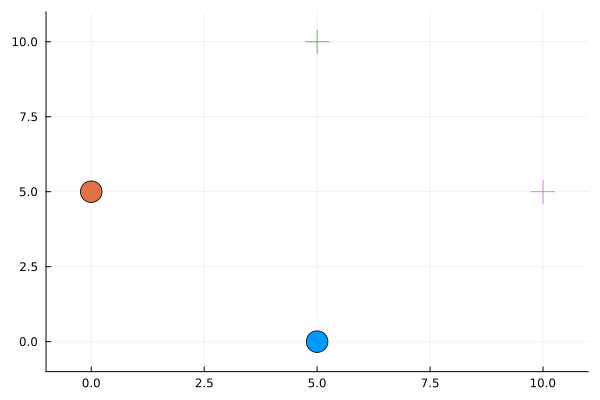

In [31]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][5]], [xₜ[t, :][6]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))
end every 1;
gif(anim, "two_agent.gif")

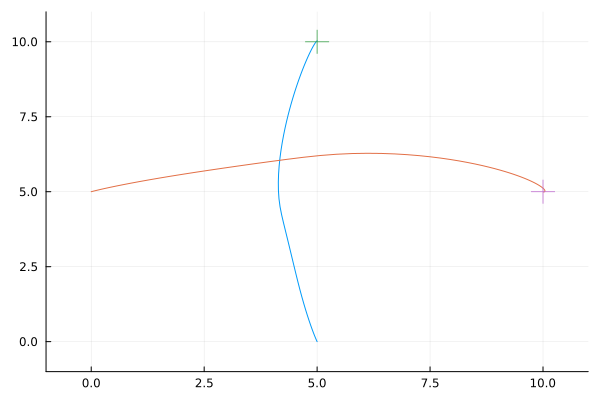

In [41]:
plot([xₜ[:, 1]], [xₜ[:, 2]], xlims = (-1, 11), ylims = (-1, 11), legend = false)
plot!([xₜ[:, 5]], [xₜ[:, 6]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12))

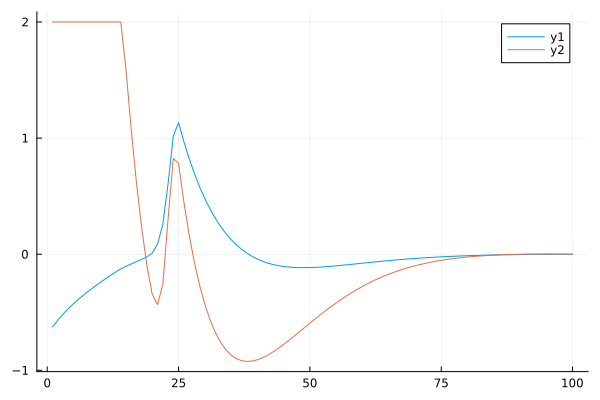

In [37]:
plot(u1ₜ)

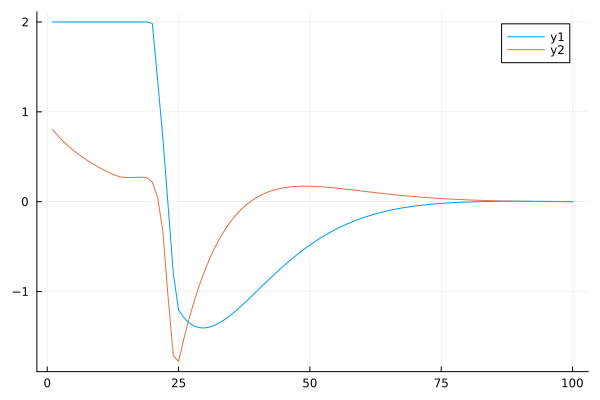

In [38]:
plot(u2ₜ)